In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the dataset
transform = transforms.Compose(
    [
        transforms.ToTensor()  # Automatically converts to tensor and scales to [0, 1]
    ]
)
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 10), nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = FashionMNISTModel()

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


# Train the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Training process
epochs = 100
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_loader, model, loss_function, optimizer)
print("Done!")


Epoch 1
-------------------------------
loss: 2.292505  [    0/60000]
loss: 0.569087  [ 6400/60000]
loss: 0.563133  [12800/60000]
loss: 0.498390  [19200/60000]
loss: 0.437595  [25600/60000]
loss: 0.626039  [32000/60000]
loss: 0.570385  [38400/60000]
loss: 0.354733  [44800/60000]
loss: 0.511651  [51200/60000]
loss: 0.532222  [57600/60000]
Epoch 2
-------------------------------
loss: 0.475519  [    0/60000]
loss: 0.624383  [ 6400/60000]
loss: 0.183673  [12800/60000]
loss: 0.388223  [19200/60000]
loss: 0.352381  [25600/60000]
loss: 0.234361  [32000/60000]
loss: 0.390089  [38400/60000]
loss: 0.498336  [44800/60000]
loss: 0.240499  [51200/60000]
loss: 0.308524  [57600/60000]
Epoch 3
-------------------------------
loss: 0.460080  [    0/60000]
loss: 0.266791  [ 6400/60000]
loss: 0.205186  [12800/60000]
loss: 0.291698  [19200/60000]
loss: 0.328982  [25600/60000]
loss: 0.287717  [32000/60000]
loss: 0.323611  [38400/60000]
loss: 0.412108  [44800/60000]
loss: 0.525263  [51200/60000]
loss: 0.34

In [ ]:
# Function to test the model
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


# Evaluate the model
test(test_loader, model)


Test Error: 
 Accuracy: 89.3%, Avg loss: 0.334304 



tensor([[ -9.2031, -10.1131,  -7.9562,  -0.0204,  -4.2867,  -7.2513,  -5.2563,
         -20.1080, -15.0160, -16.0607]])


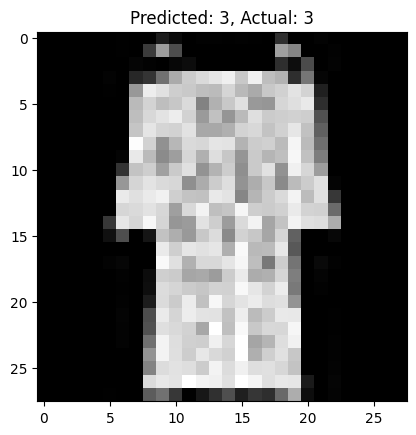

The model predicted 3, and the actual label is 3.


In [ ]:
# CHECK SINGLE PREDICTION AND PLOT
import matplotlib.pyplot as plt


def predict_single_image(image, label, model):
    # Set the model to evaluation mode
    model.eval()

    # Image needs to be unsqueezed as the model expects a batch dimension
    image = image.unsqueeze(0)

    with torch.no_grad():
        prediction = model(image)
        print(prediction)
        predicted_label = prediction.argmax(1).item()

    # Display the image and predictions
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Predicted: {predicted_label}, Actual: {label}")
    plt.show()

    return predicted_label


# Choose an image from the test set
image, label = test_dataset[33]  # Change index to test different images

# Predict the class for the chosen image
predicted_label = predict_single_image(image, label, model)
print(f"The model predicted {predicted_label}, and the actual label is {label}.")


In [ ]:
# EARLY STOPPING VERSION
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the dataset
transform = transforms.Compose(
    [
        transforms.ToTensor()  # Automatically converts to tensor and scales to [0, 1]
    ]
)
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 10), nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = FashionMNISTModel()

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


# Function to calculate accuracy
def get_accuracy(pred, labels):
    _, predictions = torch.max(pred, 1)
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy


# Train the model with accuracy reporting
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_accuracy = 0, 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = get_accuracy(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        if batch % 100 == 0:
            current = batch * len(X)
            avg_loss = total_loss / (batch + 1)
            avg_accuracy = total_accuracy / (batch + 1) * 100
            print(
                f"Batch {batch}, Loss: {avg_loss:>7f}, Accuracy: {avg_accuracy:>0.2f}% [{current:>5d}/{size:>5d}]"
            )

    # Early stopping condition
    if avg_accuracy >= 95:
        print("Reached 95% accuracy, stopping training.")
        return True  # Stop training


# Training process
epochs = 50
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    if train(
        train_loader, model, loss_function, optimizer
    ):  # Check for the early stopping signal
        print("Early stopping triggered.")
        break
print("Done!")
